In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import cmocean.cm as cmo

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 100
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

from Streamfunctions import *

### Load in data

In [4]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"

In [5]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x

In [6]:
ds = xr.open_dataset(
        datadir("/model/Southern_Ocean_WMT_Budget.nc"))

ds["BF_Adv"] = ds["surface_ocean_flux_advective_negative_rhs"]
ds["BF_NonAdv"] = ds["boundary_fluxes"] - ds["BF_Adv"]

ds["surface_boundary_fluxes"] = ds["boundary_fluxes"] - ds["bottom_flux_heat"]

ds["boundary_fluxes_heat"] = ds["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds["surface_exchange_flux_heat"] +\
                                 ds["frazil_ice_heat"] + ds["bottom_flux_heat"]

ds["boundary_fluxes_salt"] = ds["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds["surface_exchange_flux_salt"]

ds["surface_boundary_fluxes_salt"] = 1 * ds["boundary_fluxes_salt"]
ds["surface_boundary_fluxes_heat"] = ds["boundary_fluxes_heat"] - ds["bottom_flux_heat"]

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"


In [83]:
def cftime_to_decimal_year(times):
    """Convert xarray cftime to decimal years"""
    result = []
    for t in times:
        year = t.year
        start = type(t)(year, 1, 1, calendar=getattr(t, 'calendar', None))
        end = type(t)(year + 1, 1, 1, calendar=getattr(t, 'calendar', None))
        days_in_year = (end - start).days
        day_of_year = (t - start).days + (t - start).seconds / 86400.0
        result.append(year + day_of_year / days_in_year)
    return result

In [84]:
sigma = 36.974
use_averaging = True 
if use_averaging: 
    ds_yearly = ds.groupby("time.year").mean("time")
    # ds_yearly = rolling_average(ds)
    # ds_yearly = extract_winter_temps(ds)
else: 
    ds_yearly = ds.copy()
    ds_yearly.coords["time"] = cftime_to_decimal_year(ds.time.values)
    ds_yearly = ds_yearly.rename({"time":"year"})
psi40_abyssal = ds_yearly.sel(sigma2_l_target = slice(20, 37.1)).convergent_mass_transport
abyssal_dmdt = ds_yearly.sel(sigma2_l_target = slice(20, 37.1)).mass_tendency
abyssal_sbf = ds_yearly.sel(sigma2_l_target = slice(20, 37.1))["surface_boundary_fluxes"]
# ds_sigma = ds_yearly.sel(sigma2_l_target = sigma, method = "nearest")

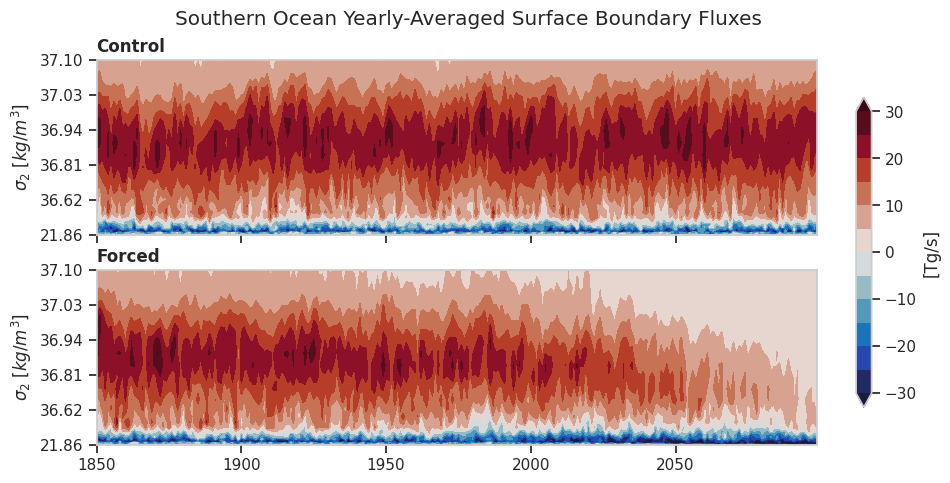

In [92]:
toTg = 1e-9 

fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)

year = psi40_abyssal.year
density =  psi40_abyssal.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-30, 30 + 0.1, 5)
ax[0].contourf(TIME,DENS, 
               toTg * abyssal_sbf.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

cm = ax[1].contourf(TIME,DENS, 
               toTg * abyssal_sbf.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

fig.colorbar(cm, ax = ax, orientation = "vertical", fraction = 0.02, label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Surface Boundary Fluxes ")
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))

# ax[1].invert_yaxis()

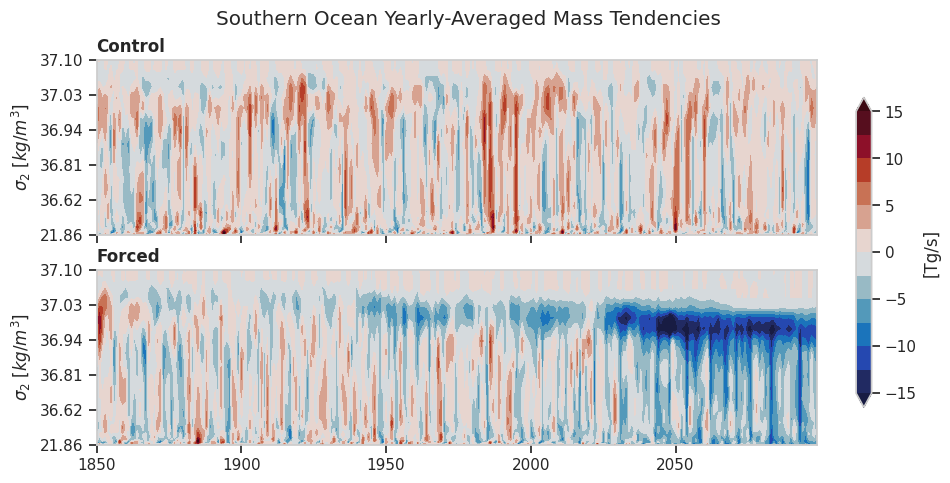

In [98]:
toTg = 1e-9 

fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)

year = psi40_abyssal.year
density =  psi40_abyssal.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-15, 15 + 0.1, 2.5)
ax[0].contourf(TIME,DENS, 
               toTg * abyssal_dmdt.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

cm = ax[1].contourf(TIME,DENS, 
               toTg * abyssal_dmdt.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

fig.colorbar(cm, ax = ax, orientation = "vertical", fraction = 0.02, label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Mass Tendencies ")
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))

# ax[1].invert_yaxis()

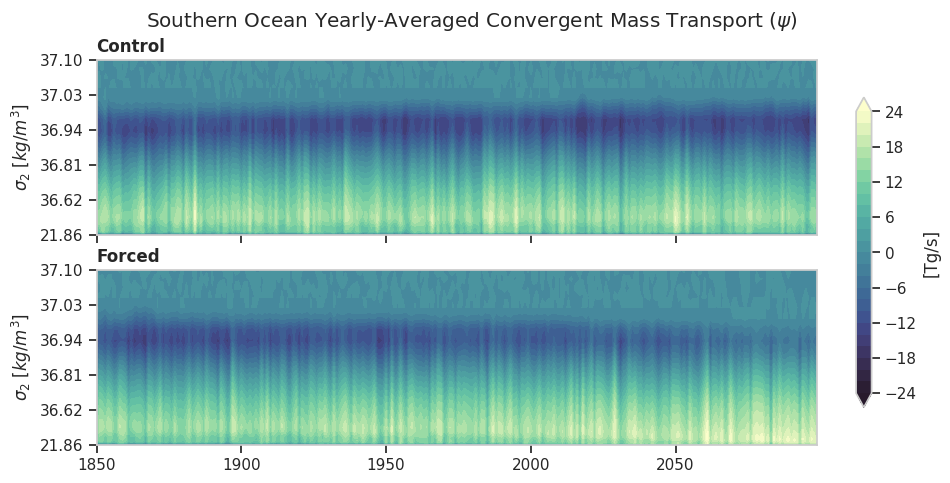

In [99]:
toTg = 1e-9 

fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)

year = psi40_abyssal.year
density =  psi40_abyssal.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-24, 24 + 0.1, 2.0)
ax[0].contourf(TIME,DENS, 
               toTg * psi40_abyssal.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.deep_r)

cm = ax[1].contourf(TIME,DENS, 
               toTg * psi40_abyssal.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.deep_r)

fig.colorbar(cm, ax = ax, orientation = "vertical", fraction = 0.02,  label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Convergent Mass Transport " + r"($\psi$)")
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))

# ax[1].invert_yaxis()

In [95]:
abyssal_sbf_crop = abyssal_sbf.sel(sigma2_l_target = slice(36.0, 37.1))
abyssal_sbf_crop = abyssal_sbf_crop.where(abyssal_sbf_crop > 0)
max_locations = abyssal_sbf_crop.argmax("sigma2_l_target")

control_max = abyssal_sbf_crop["sigma2_l_target"][max_locations.sel(exp = "control")].rename("max_surface_boundary_flux_density")
forced_max = abyssal_sbf_crop["sigma2_l_target"][max_locations.sel(exp = "forced")].rename("max_surface_boundary_flux_density")

max_sbf_loc = xr.concat([control_max, forced_max], dim = "exp")

control_max = [abyssal_sbf_crop.sel(exp = "control").sel(year = year)[max_locations.sel(exp = "control").sel(year = year)] for year in abyssal_sbf_crop.year]
control_max = xr.concat(control_max, dim = "year")
forced_max = [abyssal_sbf_crop.sel(exp = "forced").sel(year = year)[max_locations.sel(exp = "forced").sel(year = year)] for year in abyssal_sbf_crop.year]
forced_max = xr.concat(forced_max, dim = "year")
max_sbf = xr.concat([control_max, forced_max], dim = "exp")

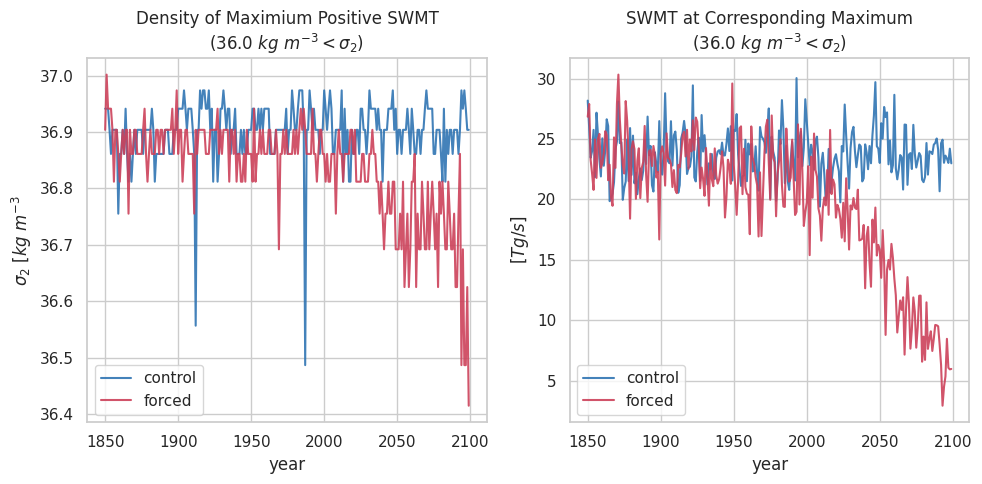

In [96]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
max_sbf_loc_rolling = max_sbf_loc.rolling(year=1, center=True).mean().dropna("year")
expts = ["control", "forced"]
for expt in expts:
    max_sbf_loc_rolling.sel(exp =expt).plot(ax = ax[0], c = expt_colors[expt], label = expt, alpha = .9)
ax[0].legend()
ax[0].set_ylabel(r"$\sigma_2 \ [kg\ m^{-3}$")
ax[0].set_title("Density of Maximium Positive SWMT\n" + r"($36.0\ kg\ m^{-3} < \sigma_2$)")

max_sbf_rolling = toTg * max_sbf.rolling(year=1, center=True).mean().dropna("year")
for expt in expts:
    max_sbf_rolling.sel(exp =expt).plot(ax = ax[1], c = expt_colors[expt], label = expt, alpha = .9)
ax[1].legend()
ax[1].set_ylabel(r"$[Tg/s]$")

ax[1].set_title("SWMT at Corresponding Maximum\n" + r"($36.0\ kg\ m^{-3} < \sigma_2$)")

fig.tight_layout()

In [97]:
def plot_heat_budget(ds, ax): 
    vcolors = sns.color_palette("tab10")[0:5]
    years = ds.year
    ax.plot(years, ds["surface_exchange_flux_heat"].values, c = "k", label = "Model Total")

    decomp_vars = ["surface_exchange_flux_nonadvective_longwave_heat", 
                    "surface_exchange_flux_nonadvective_shortwave_heat",
                    "surface_exchange_flux_nonadvective_sensible_heat",
                    "surface_exchange_flux_nonadvective_latent_heat", 
                    "surface_exchange_flux_advective_mass_transfer_heat"] #doesn't include frazil_ice but should 
    decomp_var_labels = ["Longwave", "Shortwave", "Sensible", "Latent", "Mass Transfer"]
    signs = [1, 1, 1, 1, -1]
    
    diag_total = 0 * ds["boundary_fluxes_heat"]
    for (i, var) in enumerate(decomp_vars):
        ax.plot(years, signs[i] * ds[var].values, c = vcolors[i], label = decomp_var_labels[i])
        diag_total.values += signs[i] * ds[var].values
    ax.plot(years, diag_total.values, c = "yellow", label = "Diagnosed Total")

    ax.legend()

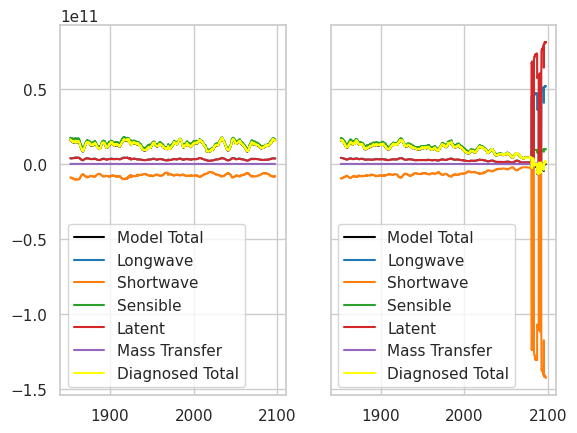

In [220]:
fig, ax = plt.subplots(1, 2, sharey = True)
plot_heat_budget(ds_yearly_AABW_dict["control"], ax[0])
plot_heat_budget(ds_yearly_AABW_dict["forced"], ax[1])

In [221]:
def plot_salt_budget(ds, ax): 
    years = ds.year
    ax.plot(years, ds["surface_boundary_fluxes_salt"].values, c = "k", label = "Model Total")

    decomp_vars = ["surface_exchange_flux_advective_evaporation_salt", 
                        "surface_exchange_flux_advective_rain_and_ice_salt",
                        "surface_exchange_flux_advective_snow_salt",
                        "surface_exchange_flux_advective_rivers_salt", 
                        "surface_exchange_flux_advective_icebergs_salt",
                        # "surface_exchange_flux_advective_virtual_precip_restoring_salt", not needed for CM4X
                        "surface_exchange_flux_advective_sea_ice_salt"] 
    #missing the nonadvective sdfsi (basal salt flux), looks like big term
    signs = [-1, -1, -1, -1, -1, -1] #basal salt will have a 1
    vcolors = sns.color_palette("tab10")[0:len(decomp_vars)]

    decomp_var_labels = ["Evaporation", "Rain/Ice-fall", "Snowfall", "River Runoff", "Icebergs Melt", "Sea Ice Melt"]

    diag_total = 0 * ds["surface_boundary_fluxes_salt"]
    for (i, var) in enumerate(decomp_vars):
        ax.plot(years, signs[i] * ds[var].values, c = vcolors[i], label = decomp_var_labels[i])
        diag_total.values += signs[i] * ds[var].values
    ax.plot(years, diag_total.values, c = "yellow", label = "Diagnosed Total", linestyle = "--")

    ax.legend()

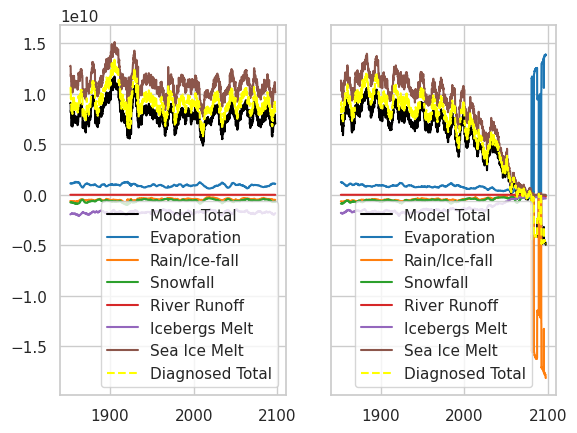

In [222]:
fig, ax = plt.subplots(1, 2, sharey = True)
plot_salt_budget(ds_yearly_AABW_dict["control"], ax[0])
plot_salt_budget(ds_yearly_AABW_dict["forced"], ax[1])

The closed numerical $\lambda$-WMT budget is given in Drake et. al 2024's Equation 43. The budget is given by: 
$$-\partial_t \mathcal{M}_\geq + \mathcal{S}_\geq + \Psi_\geq + \mathcal{G}^{BF}_\geq + \mathcal{G}^{Mix}_\geq + \mathcal{G}^{Spurious}_\geq = 0$$

Here: 
- $ \mathcal{M}(\tilde \lambda, t)_\geq = \int_\Omega \rho dV $ is the set of all waters bounded by a material surface $\tilde \lambda$
-  $\partial_t \mathcal{M}_\geq$ the rate of change of the mass of that water that is bounded by $\tilde \lambda$
    - $\tilde \lambda$ can be a density, so that $\partial_t \mathcal{M}_\geq$ describes the actual mass of waters denser than $\tilde \lambda$
    - When $\tilde \lambda$ is a density surface, $\partial_t \mathcal{M}_\geq > 0$ implies the mass of waters denser than $\tilde \lambda$ is decreasing
- If the region $\omega$ contains open boundaries (i.e. the focus is on a particular ocean), then mass is not conserved. Mass can enter freely via ocean circulation. This movement of mass along the horizontal boundaries is given by $\Psi_\geq$.
- $\mathcal{G}^{BF}_\geq$ is the contribution of mass change from boundary fluxes including mixing processes at the surface, seafloor and sea-ice.
- $\mathcal{G}^{Mix}_\geq$ includes the effects of parameterized mixing
- $\mathcal{G}^{Spurious}_\geq$ includes the effects of spurios mixing, from a models advection scheme. Obtained as a residual. 


In [11]:
toTg = 1e-9 

mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg #kg to Tg 

In [12]:
integrate = lambda dx: np.cumsum(np.concatenate([[0], dx.values]))

In [43]:
experiments = ['forced', 'control']
nexpt = len(experiments)
ds["bf_other_terms"] = ds["boundary_fluxes_heat"] + ds["boundary_fluxes_salt"] - (ds["surface_exchange_flux_heat"] + ds["surface_ocean_flux_advective_negative_rhs_salt"])

budgets = ['mass_tendency', 
           'surface_boundary_fluxes',
           # 'surface_ocean_flux_advective_negative_rhs_salt',
           'diffusion', 
           'spurious_numerical_mixing',
           'convergent_mass_transport', 
           "bottom_flux_heat",
           ]

budgets_labels = [r"$\partial_{t} \mathcal{M}_\geq$", 
                  # r"$\mathcal{G}^{SFC, \theta}_\geq$",
                  # r"$\mathcal{G}^{SFC, FW}_\geq$",
                  r"$\mathcal{G}^{SFC}_\geq$",
                  r"$\mathcal{G}^{mix}_\geq$",
                  r"$\mathcal{G}^{Spu}_\geq$",
                  r"$\Psi_\geq$", 
                  r"$\mathcal{G}^{\theta_{BOT}}_\geq$", 
                  ]
times = [("2050", "2100")]

alphas = [1, 0.4, 0.4, 0.4, 1, 0.4]
ncols = len(times)

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"

# Define the muted color palette
palette = sns.color_palette("tab10", len(budgets))

# Manually pick muted purple and brown from the palette
muted_purple = sns.color_palette("muted")[4]  # Approximate purple in "muted"
muted_brown = sns.color_palette("muted")[5]   # Approximate brown in "muted"

# Define custom colors for specific budgets
custom_colors = {
    "mass_tendency": muted_purple,
    "convergent_mass_transport": muted_brown,
}

# Generate colors for remaining variables
remaining_budgets = [budget for budget in budgets if budget not in custom_colors]
remaining_palette = sns.color_palette("muted", len(remaining_budgets))
remaining_colors = {budget: remaining_palette[i] for i, budget in enumerate(remaining_budgets)}

# Combine the custom colors and remaining colors into one dictionary
var_colors = {**custom_colors, **remaining_colors}

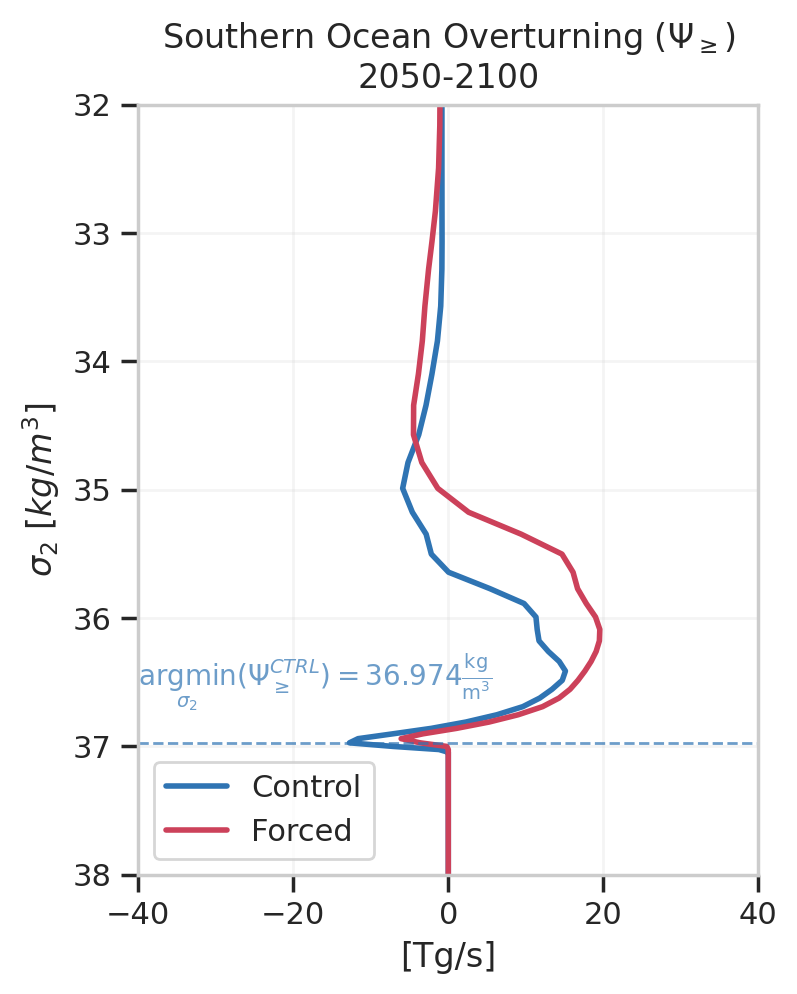

In [150]:
times = ("2050", "2100")
ds_mean = ds.sel(time = slice(times[0], times[1])).mean("time")
fig, ax = plt.subplots(figsize = (4, 5),sharey = True, sharex = True)

ax.set_title("Southern Ocean Overturning" + r" $(\Psi_\geq)$" + "\n2050-2100")
ax.plot(mass_flux_units_conversion * ds_mean.sel(exp = "control")['convergent_mass_transport'], 
           ds_mean.sigma2_l_target, lw = 2.0, label = "Control",
          c = expt_colors['control'])
ax.plot(mass_flux_units_conversion * ds_mean.sel(exp = "forced")['convergent_mass_transport'], 
           ds_mean.sigma2_l_target, lw = 2.0, label = "Forced", 
          c = expt_colors['forced'])

ax.axhline([36.974], c = expt_colors['control'], alpha = 0.7, lw = 1, linestyle = "--")
ax.annotate(r'$\underset{\sigma_2}{\mathrm{argmin}} (\Psi^{CTRL}_\geq)$' + r'$= 36.974 \mathrm{\frac{kg}{m^3}}$', 
            xy=(-40., 36.5), fontsize = 10, 
            xytext=(0, 0), textcoords="offset points",
            va="center", c = expt_colors['control'], alpha = 0.7)

ax.legend(loc = "lower left", markerscale=0.5)
# [a.legend() for a in ax]
ax.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
ax.set_xlabel("[Tg/s]")
ax.set_ylim(32, 38)
ax.set_xlim(-40, 40)
ax.invert_yaxis()
ax.grid(alpha = 0.2)
ax.tick_params(bottom=True, left=True)
fig.savefig(plotsdir("paper_figures/SO_Psi_Profile.png"), dpi = 200, bbox_inches = "tight")

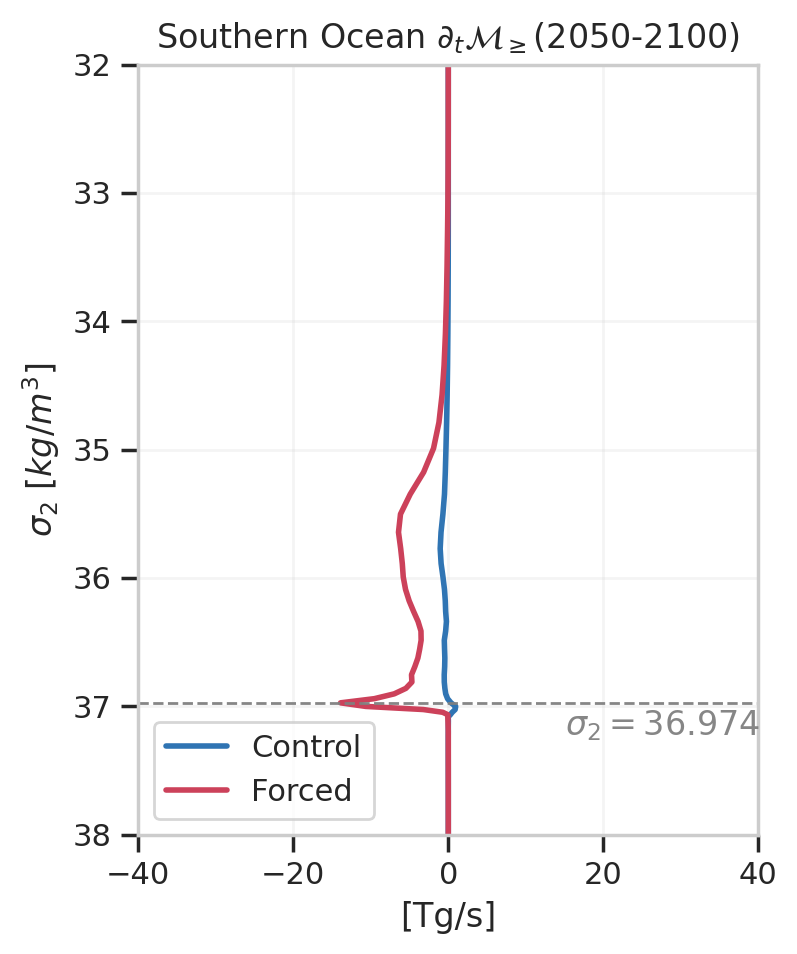

In [152]:
times = ("2050", "2100")
ds_mean = ds.sel(time = slice(times[0], times[1])).mean("time")
fig, ax = plt.subplots(figsize = (4, 5),sharey = True, sharex = True)

ax.set_title("Southern Ocean " + r"$\partial_{t} \mathcal{M}_\geq$" + "(2050-2100)")
ax.plot(mass_flux_units_conversion * ds_mean.sel(exp = "control")['mass_tendency'], 
           ds_mean.sigma2_l_target, lw = 2.0, label = "Control",
          c = expt_colors['control'])
ax.plot(mass_flux_units_conversion * ds_mean.sel(exp = "forced")['mass_tendency'], 
           ds_mean.sigma2_l_target, lw = 2.0, label = "Forced", 
          c = expt_colors['forced'])

ax.axhline([36.974], c = "grey", alpha = 0.95, lw = 1, linestyle = "--")
ax.annotate(r"$\sigma_2 = 36.974$", xy=(15., 37.15), fontsize = 12,
              xytext=(0, 0), textcoords="offset points",
              va="center", c = "grey", alpha = 0.95)

ax.legend(loc = "lower left", markerscale=0.5)
# [a.legend() for a in ax]
ax.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
ax.set_xlabel("[Tg/s]")
ax.set_ylim(32, 38)
ax.set_xlim(-40, 40)
ax.invert_yaxis()
ax.grid(alpha = 0.2)
ax.tick_params(bottom=True, left=True)
fig.savefig(plotsdir("paper_figures/SO_dMdt_Profile.png"), dpi = 200, bbox_inches = "tight")

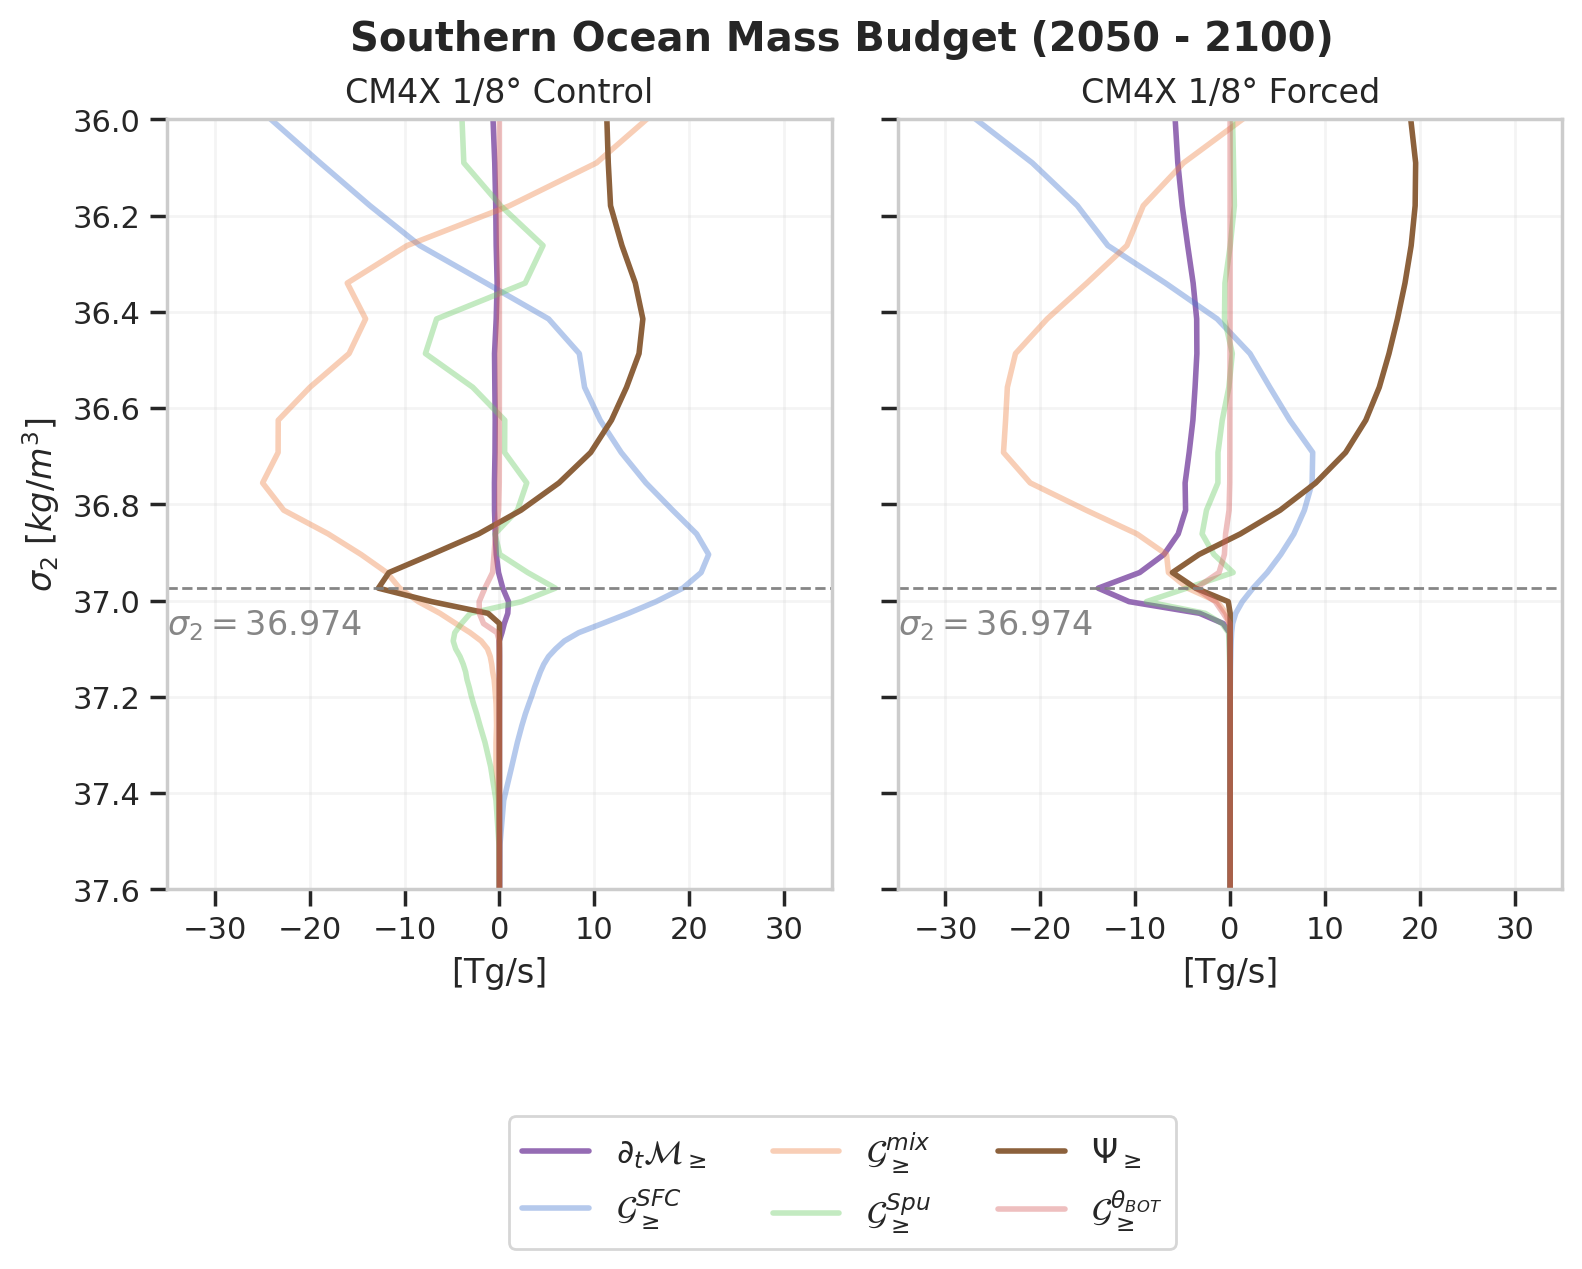

In [153]:
times = ("2050", "2100")
ds_mean = ds.sel(time = slice(times[0], times[1])).mean("time")
fig, ax = plt.subplots(1, 2, figsize = (9, 5),sharey = True, sharex = True)
fig.suptitle("Southern Ocean Mass Budget (2050 - 2100)", fontweight = "bold")
for (i, exp) in enumerate(budgets):
    ax[1].set_title("CM4X 1/8° Forced")
    ax[1].plot(mass_flux_units_conversion * ds_mean.sel(exp = "forced")[exp], 
               ds_mean.sigma2_l_target, 
               label = budgets_labels[i], lw = 2.0,alpha = alphas[i], 
              c = var_colors[exp])
    ax[0].set_title("CM4X 1/8° Control")
    ax[0].plot(mass_flux_units_conversion * ds_mean.sel(exp = "control")[exp], 
               ds_mean.sigma2_l_target,
               # label = budgets_labels[i], 
               lw = 2.0,alpha = alphas[i], 
              c = var_colors[exp])

for a in ax:
    a.axhline([36.974], c = "grey", alpha = 0.95, lw = 1, linestyle = "--")
    a.annotate(r"$\sigma_2 = 36.974$", xy=(-35., 37.05), fontsize = 12,
                      xytext=(0, 0), textcoords="offset points",
                      va="center", c = "grey", alpha = 0.95)
    a.tick_params(bottom=True, left=True)
# ax[0].legend()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize = 12)
fig.subplots_adjust(wspace = 0.1)
ax[0].set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
[a.set_xlabel("[Tg/s]") for a in ax]
ax[1].set_ylim(36, 37.6)
ax[1].set_xlim(-35, 35)
ax[1].invert_yaxis()
[a.grid(alpha = 0.2) for a in  ax]
fig.savefig(plotsdir("paper_figures/Mass_Budget_Profile_Budget.png"), dpi = 200, bbox_inches = "tight")

In [157]:
# sigma = 37.00
sigma = 36.974
times = [("2050", "2100")]

In [158]:
tendencies = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest").compute()
tendencies = tendencies.groupby("time.year").mean("time")
tendencies = tendencies.sel(year = slice("1850", None))

-13.90471660729884
0.3515832225817309


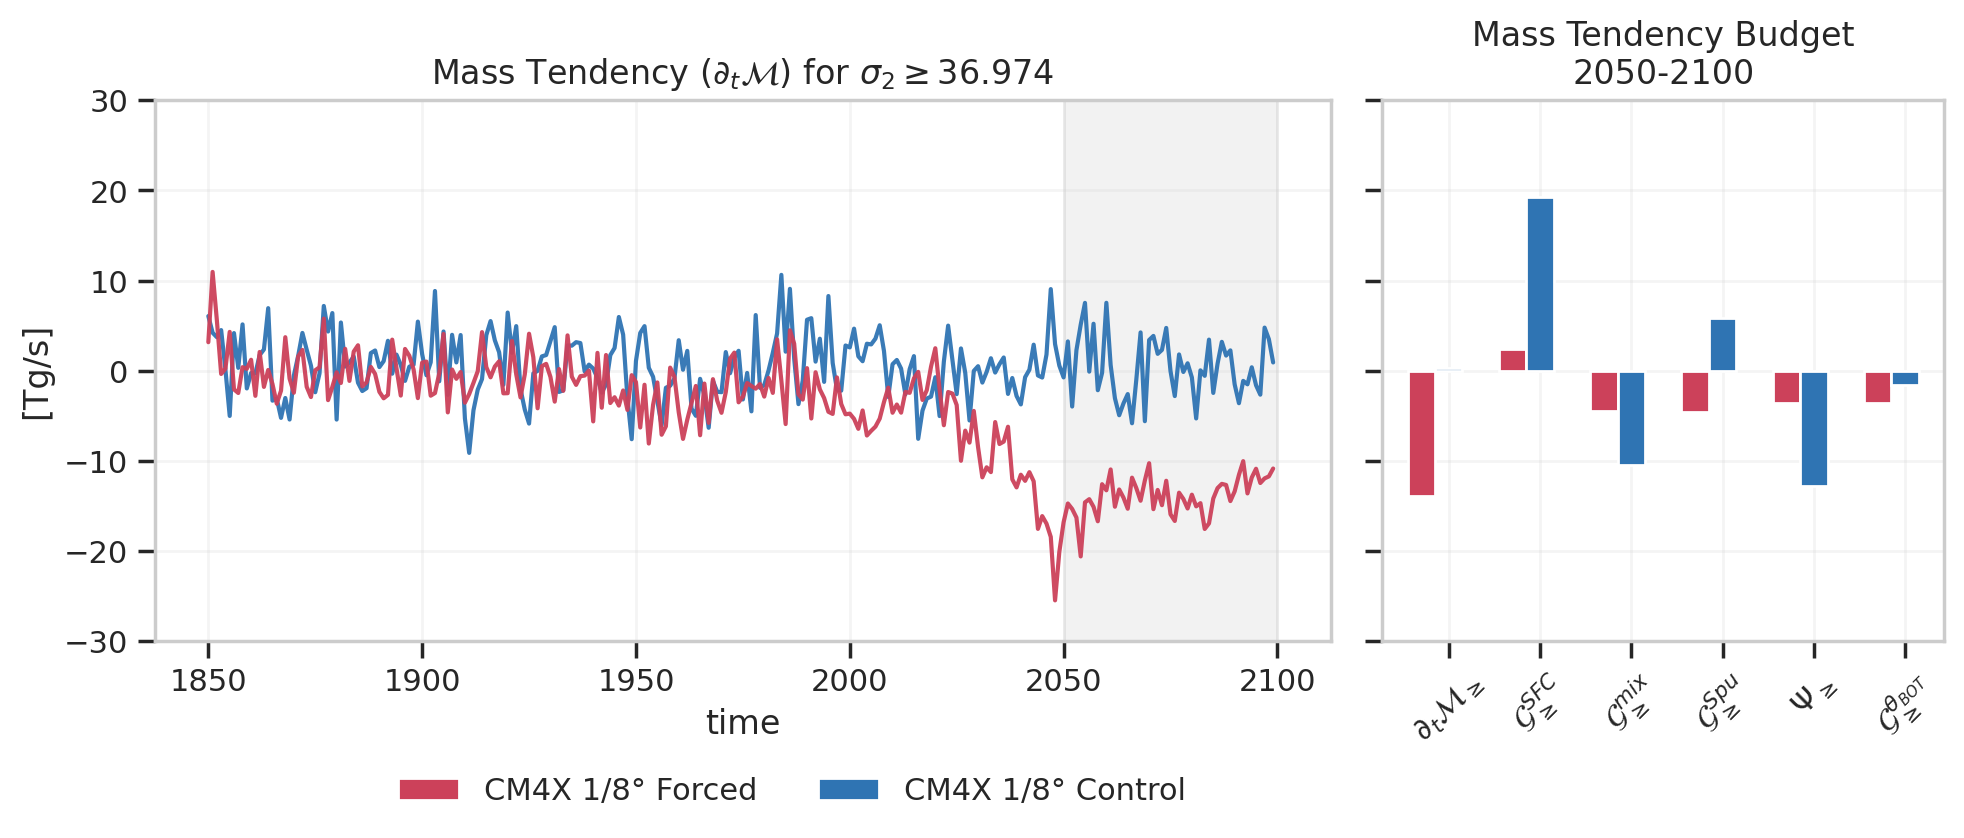

In [171]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 4 columns, where the first plot takes up 3/4 and the second takes 1/4
gs = gridspec.GridSpec(1, 6)

###### PLOT 1. TIME SERIES ###########
ax1 = fig.add_subplot(gs[0, :4])
ax = ax1
ax.grid(alpha = 0.4, axis = "y")
width = 0.3

ax.grid(alpha = 0.2)

ax.plot(tendencies.year, tendencies["mass_tendency"].sel(exp = "control"), 
        label = "CM4Xp125\ncontrol", linewidth = 1.5, alpha = 0.95, c = expt_colors["control"])

ax.plot(tendencies.year, tendencies["mass_tendency"].sel(exp = "forced"), 
        label = "CM4Xp125\nforced", linewidth = 1.5, alpha = 0.95, c = expt_colors["forced"])

ax.set_ylabel(f"[{mass_flux_units}]")

ax.set_title("Mass Tendency " + r"$(\partial_{t} \mathcal{M})$" + " for " + r"$\sigma_2 \geq 36.974$")
ax.set_xlabel("time")
ax.tick_params(bottom=True, left=True)

ax.axvspan(2050, 2100, color='grey' , alpha=0.1, zorder = 0)

###### PLOT 2. BAR PLOT ###########
ax2 = fig.add_subplot(gs[0, 4:], sharey = ax1)
ax = ax2
for (it, t) in enumerate(times):
    wmt_mean = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest")
    wmt_mean = wmt_mean.sel(time = slice(t[0], t[1])).mean("time")
    curr_width = 0.0
    for (i, exp) in enumerate(experiments):

        wmt_mean_budget =  wmt_mean.sel(exp = exp)
        print(wmt_mean_budget['mass_tendency'].values)
        bvalues = [wmt_mean_budget[k].values for k in budgets]
    
        nterms = np.arange(len(budgets_labels))
    
        ax.bar(nterms + curr_width, bvalues, label = "CM4X 1/8° " + exp.capitalize(), 
                  width = width, color = expt_colors[exp])
        curr_width += width
    
ax.grid(alpha = 0.2)
ax.set_xticks(np.arange(len(budgets_labels)) + width, budgets_labels, rotation = 45)
ax.set_title("Mass Tendency Budget\n" + '-'.join(t))
# ax.set_ylabel(f"[{mass_flux_units}]")
fig.tight_layout()
ax.legend(ncols = 2, bbox_to_anchor = (-0.3, -0.2), frameon = False)
ax.tick_params(bottom=True, left=True, labelleft=False)
fig.subplots_adjust(wspace = 0.2)
[a.set_ylim(-30, 30) for a in [ax1, ax2]]
fig.savefig(plotsdir(f"paper_figures/dMdt_sigma_{sigma}.png"), bbox_inches = "tight", dpi = dpi)

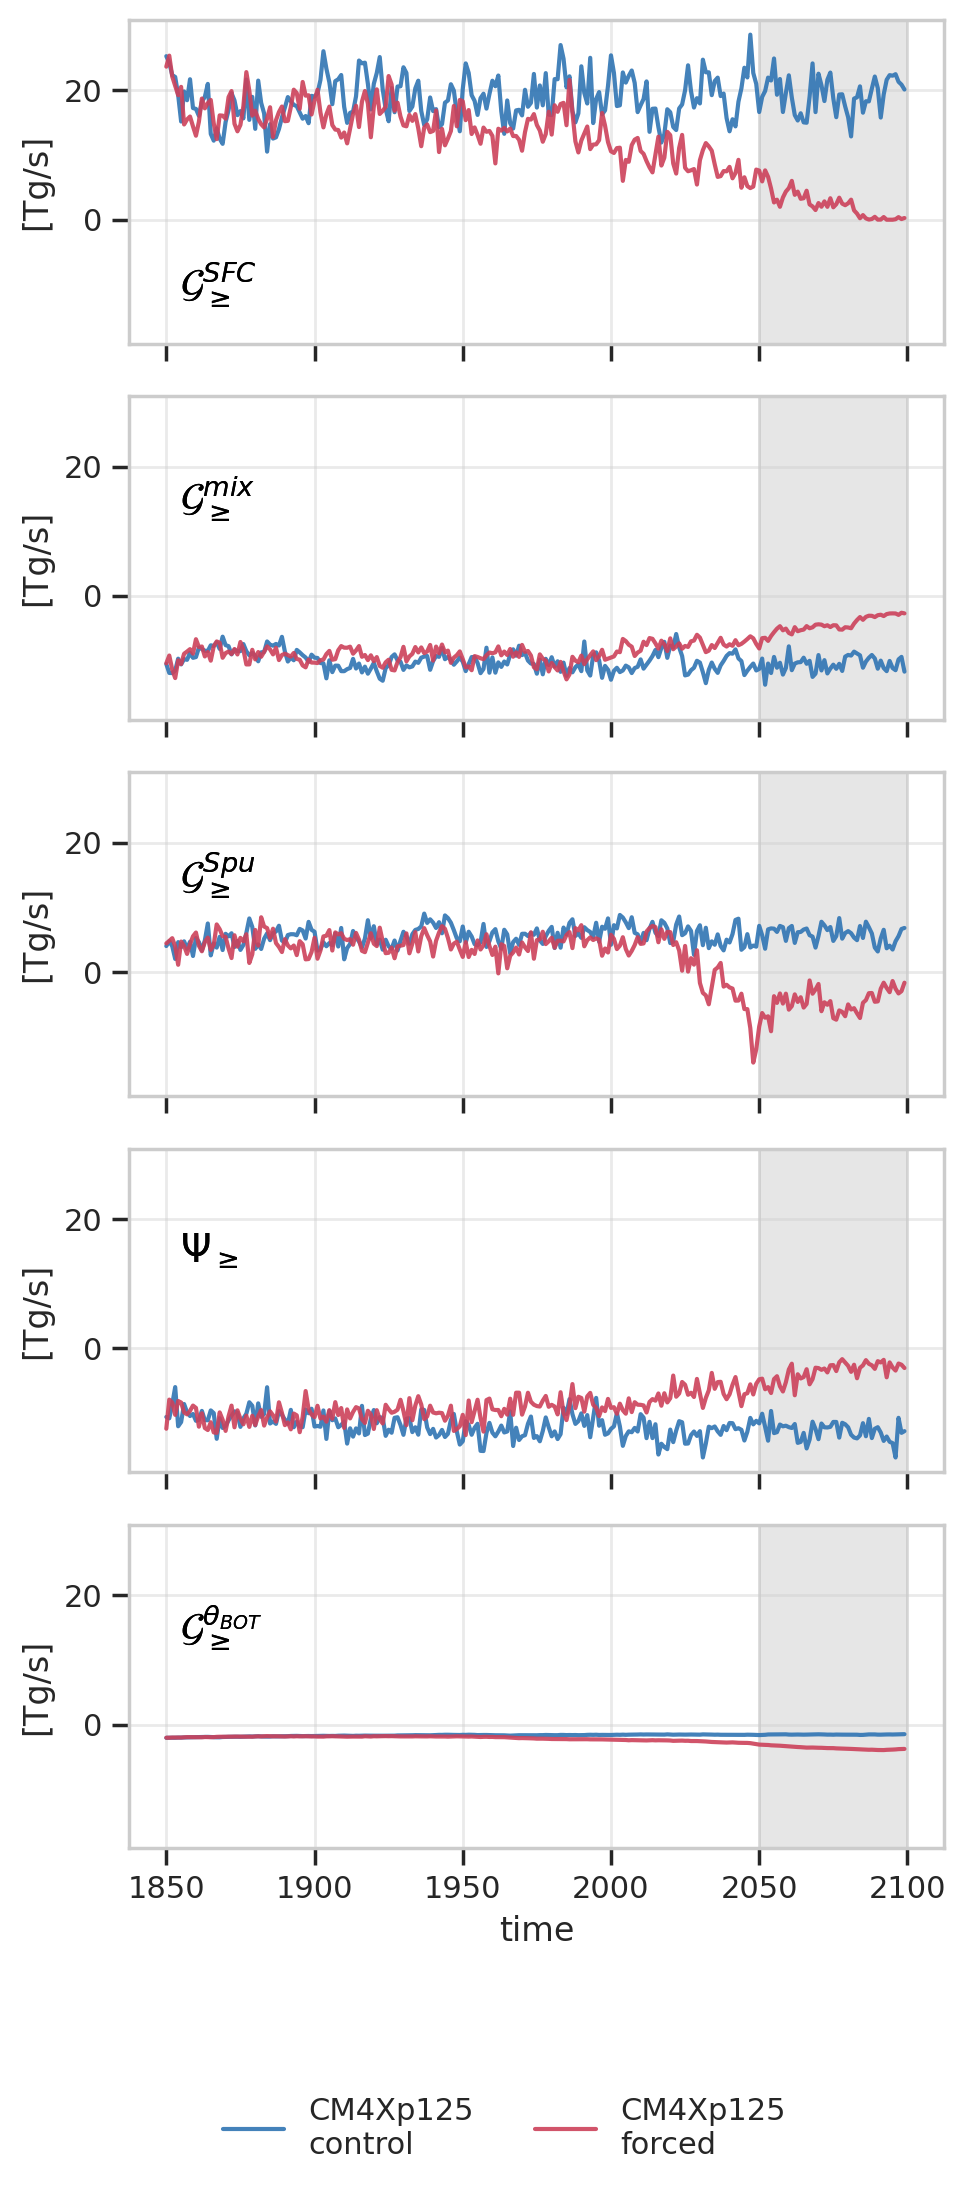

In [172]:
tendencies = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest").compute()

tendencies_std = tendencies.groupby("time.year").std("time")
tendencies_std = tendencies_std.sel(year = slice("1850", None))

tendencies = tendencies.groupby("time.year").mean("time")
tendencies = tendencies.sel(year = slice("1850", None))

budget_colors = sns.color_palette("Dark2")

budgets = ['surface_boundary_fluxes',
           # 'surface_exchange_flux_heat',
           # 'surface_ocean_flux_advective_negative_rhs_salt',
           'diffusion', 
           'spurious_numerical_mixing',
           'convergent_mass_transport', 
           "bottom_flux_heat",
           ]

budgets_labels = [r"$\mathcal{G}^{SFC}_\geq$",
                  # r"$\mathcal{G}^{SFC, \theta}_\geq$",
                  # r"$\mathcal{G}^{SFC, FW}_\geq$",
                  r"$\mathcal{G}^{mix}_\geq$",
                  r"$\mathcal{G}^{Spu}_\geq$",
                  r"$\Psi_\geq$", 
                  r"$\mathcal{G}^{\theta_{BOT}}_\geq$", 

                  ]

fig, axes = plt.subplots(len(budgets), 1, figsize = (5, 10), 
                         sharex = True, sharey = True)

for (j, expt) in enumerate(["control", "forced"]):
    for i in range(len(budgets)):
        ax = axes[i]
        ax.grid(alpha = 0.4)
        ax.plot(tendencies.year, tendencies[budgets[i]].sel(exp = expt), 
                label = f"CM4Xp125\n{expt}", linewidth = 1.5, 
                alpha = 0.9, c = expt_colors[expt])
            
        ax.tick_params(bottom=True, left=True)
        ax.axvspan(2050, 2100, color='grey' , alpha=0.1, zorder = 0)
        # ax.set_title(budgets_labels[i])

        if i == 0: 
            xy = (1850, -10)    
        else: 
            xy = (1850, 15)    
        ax.annotate(budgets_labels[i], xy=xy, fontsize = 14, 
                    xytext=(5, 0), textcoords="offset points",
                  va="center", c = "k")
        
[a.set_ylabel(f"[{mass_flux_units}]") for a in axes]
# [ax.set_xlabel("time") for ax in axes[2:4]]
axes[-1].set_xlabel("time")

fig.subplots_adjust(hspace = 0.25, wspace = 0.1)
fig.tight_layout()
axes[-1].legend(ncols = 2, loc = (0.1, -1), frameon = False)
fig.savefig(plotsdir(f"paper_figures/budget_sigma_{sigma}.png"), 
            bbox_inches = "tight", dpi = dpi)